In [1]:
import copy
import time
import random

import pandas as pd
import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette='summer')

import transformers
import datasets

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Глобальные переменные

In [3]:
TEST = False
RANDOM_STATE = 42
RUBERT_NAME = 'cointegrated/rubert-tiny2'
MATHBERT_NAME = 'tbs17/MathBert'
MAX_LENGTH = 256
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
EPOCHS = 5

In [4]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

## Загрузка данных

In [5]:
math_dataset = datasets.load_dataset(
    'csv', data_files='/kaggle/input/final-homework/data_problems_translated.csv', split='train'
)
math_dataset = math_dataset.remove_columns('Unnamed: 0')
math_dataset = math_dataset.rename_columns({'problem_text': 'text', 'topic': 'label'})
math_dataset = math_dataset.class_encode_column('label')

math_dataset = math_dataset.train_test_split(test_size=.2, shuffle=True, stratify_by_column='label')

Generating train split: 0 examples [00:00, ? examples/s]

Casting to class labels:   0%|          | 0/5273 [00:00<?, ? examples/s]

In [6]:
id2label = dict(zip( 
    range(len(math_dataset['test'].features['label'].names)),
    math_dataset['test'].features['label'].names
))
label2id = dict(zip(
    math_dataset['test'].features['label'].names,
    range(len(math_dataset['test'].features['label'].names))
))

In [7]:
id2label

{0: 'combinatorics',
 1: 'dirichlet',
 2: 'geometry',
 3: 'graphs',
 4: 'invariant',
 5: 'number_theory',
 6: 'polynoms'}

In [8]:
label2id

{'combinatorics': 0,
 'dirichlet': 1,
 'geometry': 2,
 'graphs': 3,
 'invariant': 4,
 'number_theory': 5,
 'polynoms': 6}

In [9]:
math_dataset['train'][1]

{'text': "Prove that the root of a multi-member P(x) has a multiple of more than 1 then and only when P(a) = 0 and P'(a) = 0.",
 'label': 6}

## Dataset

Напишем кастомный класс датасета, который будет работать с табличными данными и подготовливать их для взаимосдействия с моделью.

In [10]:
class LocalDataset(Dataset):
    def __init__(self, data, tokenizer, split_name):
        self.split_name = split_name
        self.data = data[self.split_name]
        self.tokenizer = tokenizer
        self.len = len(self.data)
        
    def __getitem__(self, index):
        sample = self.data[index]
        inputs = self.tokenizer(
            sample['text'], 
            add_special_tokens=True, 
            max_length=MAX_LENGTH, 
            padding='max_length',
            truncation=True
        )
        ids = inputs['input_ids'] 
        mask = inputs['attention_mask']
        targets = sample['label']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(targets, dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [11]:
class TransformerClassificationModel(nn.Module):
    def __init__(
        self, base_transformer_model: str,
        num_classes: int,
        middle_shape: int = 768
        ):
        super().__init__()

        self.backbone = transformers.AutoModel.from_pretrained(
            base_transformer_model
            )
        # Label head
        self.avgpool = nn.AdaptiveAvgPool2d((1, middle_shape))
        self.classification = nn.Sequential(
            nn.Linear(in_features=middle_shape, out_features=1024, bias=True),
            nn.Hardswish(),
            nn.Dropout(p=.2, inplace=True),
            nn.Linear(in_features=1024, out_features=num_classes, bias=True)
        )

    def forward(self, input_ids, attention_mask):
        inputs = self.backbone(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )
        inputs = self.avgpool(inputs.last_hidden_state)
        inputs = torch.flatten(inputs, 1)
        logits = self.classification(inputs)
        return logits

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [12]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [13]:
def train_transformer(transformer_model, train_dataloader, test_dataloader, freeze_backbone=True):
    model = copy.copy(transformer_model)
    if freeze_backbone:
        model = freeze_backbone_function(model=model)
    # Model to device
    model = model.to(device)
    # Creating the loss function and optimizer
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE, weight_decay=.1)
    # Scaler for average precision training
    scaler = torch.cuda.amp.GradScaler(enabled=True)
    
    for epoch in range(EPOCHS):
        # Each epoch has a training and test phase
        for phase in ['Train', 'Test']:
            if phase == 'Train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = test_dataloader
                model.eval()  # Set model to evaluate mode
                
            running_loss = 0.
            running_acc = 0.
            
            with tqdm.tqdm(dataloader, unit='batch') as tqdm_loader:
                for data in tqdm_loader:
                    tqdm_loader.set_description(f'Epoch {epoch}/{EPOCHS-1} - {phase}')
                    ids = data['ids'].to(device, dtype = torch.long)
                    mask = data['mask'].to(device, dtype = torch.long)
                    targets = data['targets'].to(device, dtype = torch.long)
                    
                    optimizer.zero_grad()
                    # forward and backward
                    with torch.set_grad_enabled(phase == 'Train'):
                        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
                            outputs = model(ids, mask)
                            predict_class = outputs.argmax(dim=1)
                            loss = loss_function(outputs, targets)
                        # backward + optimize only if in training phase
                        if phase == 'Train':
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                    # statistics
                    loss_item = loss.item()
                    running_loss += loss_item
                    acc_value = (predict_class == targets).float().mean().item()
                    running_acc += acc_value
                    # Current statistics
                    tqdm_loader.set_postfix(Loss=loss_item, Accuracy=acc_value)
                    time.sleep(.1)
                    
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            
    model = model.cpu()
    return model

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [14]:
rubert_tiny_tokenizer = transformers.AutoTokenizer.from_pretrained(RUBERT_NAME)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [15]:
if TEST:
    model_test = TransformerClassificationModel(
        base_transformer_model=RUBERT_NAME,
        num_classes=len(id2label),
        middle_shape=312
        )
    model_test.eval();
    text = "Replace me by any text you'd like d."
    encoded_input = rubert_tiny_tokenizer(
        text,      
        add_special_tokens=True, 
        max_length=MAX_LENGTH, 
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    output = model_test(encoded_input['input_ids'], encoded_input['attention_mask'])

    print(f'Basic model output: {output.shape}')

In [16]:
# Datasets
train_dataset_rubert_tiny = LocalDataset(
        data=math_dataset,
        tokenizer=rubert_tiny_tokenizer,
        split_name='train'
    )
test_dataset_rubert_tiny = LocalDataset(
        data=math_dataset,
        tokenizer=rubert_tiny_tokenizer,
        split_name='test'
    )
# Dataloaders
train_dataloader_rubert_tiny = torch.utils.data.DataLoader(
    train_dataset_rubert_tiny,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True
)
test_dataloader_rubert_tiny = torch.utils.data.DataLoader(
    test_dataset_rubert_tiny,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

In [17]:
rubert_tiny_init = TransformerClassificationModel(
    base_transformer_model=RUBERT_NAME, num_classes=len(id2label), middle_shape=312
)
rubert_tiny_finetuned_with_freezed_backbone = TransformerClassificationModel(
    base_transformer_model=RUBERT_NAME, num_classes=len(id2label), middle_shape=312
)
rubert_tiny_transformer_model = TransformerClassificationModel(
    base_transformer_model=RUBERT_NAME, num_classes=len(id2label), middle_shape=312
)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

In [18]:
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(
    transformer_model=rubert_tiny_finetuned_with_freezed_backbone, 
    train_dataloader=train_dataloader_rubert_tiny, 
    test_dataloader=test_dataloader_rubert_tiny, 
    freeze_backbone=True
)
rubert_tiny_transformer_model = train_transformer(
    transformer_model=rubert_tiny_transformer_model, 
    train_dataloader=train_dataloader_rubert_tiny, 
    test_dataloader=test_dataloader_rubert_tiny, 
    freeze_backbone=False
)

Epoch 0/4 - Train: 100%|██████████| 132/132 [00:22<00:00,  5.83batch/s, Accuracy=0.462, Loss=1.54]

Train Loss: 1.5797 Acc: 0.4382



Epoch 0/4 - Test: 100%|██████████| 33/33 [00:05<00:00,  6.59batch/s, Accuracy=0.613, Loss=1.26]

Test Loss: 1.4508 Acc: 0.4599



Epoch 1/4 - Train: 100%|██████████| 132/132 [00:20<00:00,  6.39batch/s, Accuracy=0.269, Loss=1.58]

Train Loss: 1.3965 Acc: 0.4852



Epoch 1/4 - Test: 100%|██████████| 33/33 [00:05<00:00,  6.58batch/s, Accuracy=0.548, Loss=1.18]

Test Loss: 1.3400 Acc: 0.5147



Epoch 2/4 - Train: 100%|██████████| 132/132 [00:20<00:00,  6.40batch/s, Accuracy=0.692, Loss=1.1] 

Train Loss: 1.3004 Acc: 0.5322



Epoch 2/4 - Test: 100%|██████████| 33/33 [00:04<00:00,  6.61batch/s, Accuracy=0.581, Loss=1.11]

Test Loss: 1.2681 Acc: 0.5327



Epoch 3/4 - Train: 100%|██████████| 132/132 [00:20<00:00,  6.39batch/s, Accuracy=0.577, Loss=1.08]

Train Loss: 1.2355 Acc: 0.5456



Epoch 3/4 - Test: 100%|██████████| 33/33 [00:05<00:00,  6.59batch/s, Accuracy=0.613, Loss=1.07] 

Test Loss: 1.2259 Acc: 0.5536



Epoch 4/4 - Train: 100%|██████████| 132/132 [00:20<00:00,  6.41batch/s, Accuracy=0.538, Loss=1.2]  

Train Loss: 1.1905 Acc: 0.5602



Epoch 4/4 - Test: 100%|██████████| 33/33 [00:05<00:00,  6.56batch/s, Accuracy=0.613, Loss=1.04]

Test Loss: 1.2035 Acc: 0.5536



Epoch 0/4 - Train: 100%|██████████| 132/132 [00:27<00:00,  4.79batch/s, Accuracy=0.462, Loss=1.42] 

Train Loss: 1.3542 Acc: 0.5134



Epoch 0/4 - Test: 100%|██████████| 33/33 [00:05<00:00,  6.56batch/s, Accuracy=0.581, Loss=1]    

Test Loss: 1.1682 Acc: 0.5630



Epoch 1/4 - Train: 100%|██████████| 132/132 [00:27<00:00,  4.80batch/s, Accuracy=0.731, Loss=0.906]

Train Loss: 1.0251 Acc: 0.6223



Epoch 1/4 - Test: 100%|██████████| 33/33 [00:05<00:00,  6.58batch/s, Accuracy=0.742, Loss=0.818]

Test Loss: 1.0518 Acc: 0.5935



Epoch 2/4 - Train: 100%|██████████| 132/132 [00:27<00:00,  4.81batch/s, Accuracy=0.577, Loss=0.929]

Train Loss: 0.8795 Acc: 0.6665



Epoch 2/4 - Test: 100%|██████████| 33/33 [00:04<00:00,  6.61batch/s, Accuracy=0.71, Loss=0.789] 

Test Loss: 1.0714 Acc: 0.5878



Epoch 3/4 - Train: 100%|██████████| 132/132 [00:27<00:00,  4.79batch/s, Accuracy=0.692, Loss=0.647]

Train Loss: 0.7772 Acc: 0.6977



Epoch 3/4 - Test: 100%|██████████| 33/33 [00:05<00:00,  6.60batch/s, Accuracy=0.645, Loss=0.806]

Test Loss: 1.0932 Acc: 0.5896



Epoch 4/4 - Train: 100%|██████████| 132/132 [00:27<00:00,  4.80batch/s, Accuracy=0.692, Loss=0.854]

Train Loss: 0.6761 Acc: 0.7325



Epoch 4/4 - Test: 100%|██████████| 33/33 [00:05<00:00,  6.59batch/s, Accuracy=0.677, Loss=0.852]

Test Loss: 1.1334 Acc: 0.5755


### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

In [19]:
math_bert_tokenizer = transformers.AutoTokenizer.from_pretrained(MATHBERT_NAME)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
# Datasets
train_dataset_math_bert = LocalDataset(
        data=math_dataset,
        tokenizer=math_bert_tokenizer,
        split_name='train'
    )
test_dataset_math_bert = LocalDataset(
        data=math_dataset,
        tokenizer=math_bert_tokenizer,
        split_name='test'
    )
# Dataloaders
train_dataloader_math_bert = torch.utils.data.DataLoader(
    train_dataset_math_bert,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True
)
test_dataloader_math_bert = torch.utils.data.DataLoader(
    test_dataset_math_bert,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

In [21]:
math_bert_init = TransformerClassificationModel(
    base_transformer_model=MATHBERT_NAME, num_classes=len(id2label), middle_shape=768
)
math_bert_finetuned_with_freezed_backbone = TransformerClassificationModel(
    base_transformer_model=MATHBERT_NAME, num_classes=len(id2label), middle_shape=768
)
math_bert_transformer_model = TransformerClassificationModel(
    base_transformer_model=MATHBERT_NAME, num_classes=len(id2label), middle_shape=768
)

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [22]:
math_bert_finetuned_with_freezed_backbone = train_transformer(
    transformer_model=math_bert_finetuned_with_freezed_backbone, 
    train_dataloader=train_dataloader_math_bert, 
    test_dataloader=test_dataloader_math_bert, 
    freeze_backbone=True
)
math_bert_transformer_model = train_transformer(
    transformer_model=math_bert_transformer_model, 
    train_dataloader=train_dataloader_math_bert, 
    test_dataloader=test_dataloader_math_bert,
    freeze_backbone=False
)

Epoch 0/4 - Train: 100%|██████████| 132/132 [00:35<00:00,  3.68batch/s, Accuracy=0.615, Loss=1.28]

Train Loss: 1.4825 Acc: 0.4644



Epoch 0/4 - Test: 100%|██████████| 33/33 [00:08<00:00,  3.90batch/s, Accuracy=0.581, Loss=1.16]

Test Loss: 1.3366 Acc: 0.5072



Epoch 1/4 - Train: 100%|██████████| 132/132 [00:36<00:00,  3.66batch/s, Accuracy=0.654, Loss=0.993]

Train Loss: 1.2441 Acc: 0.5480



Epoch 1/4 - Test: 100%|██████████| 33/33 [00:08<00:00,  3.89batch/s, Accuracy=0.645, Loss=1]    

Test Loss: 1.2030 Acc: 0.5470



Epoch 2/4 - Train: 100%|██████████| 132/132 [00:36<00:00,  3.65batch/s, Accuracy=0.769, Loss=0.93] 

Train Loss: 1.1268 Acc: 0.5787



Epoch 2/4 - Test: 100%|██████████| 33/33 [00:08<00:00,  3.87batch/s, Accuracy=0.645, Loss=0.949]

Test Loss: 1.1519 Acc: 0.5697



Epoch 3/4 - Train: 100%|██████████| 132/132 [00:36<00:00,  3.63batch/s, Accuracy=0.654, Loss=0.881]

Train Loss: 1.0618 Acc: 0.6023



Epoch 3/4 - Test: 100%|██████████| 33/33 [00:08<00:00,  3.85batch/s, Accuracy=0.677, Loss=0.912]

Test Loss: 1.1321 Acc: 0.5698



Epoch 4/4 - Train: 100%|██████████| 132/132 [00:36<00:00,  3.62batch/s, Accuracy=0.577, Loss=1.06] 

Train Loss: 1.0245 Acc: 0.6109



Epoch 4/4 - Test: 100%|██████████| 33/33 [00:08<00:00,  3.83batch/s, Accuracy=0.645, Loss=0.882]

Test Loss: 1.1189 Acc: 0.5754



Epoch 0/4 - Train: 100%|██████████| 132/132 [01:14<00:00,  1.76batch/s, Accuracy=0.654, Loss=1.12] 

Train Loss: 1.1193 Acc: 0.5940



Epoch 0/4 - Test: 100%|██████████| 33/33 [00:08<00:00,  3.81batch/s, Accuracy=0.645, Loss=0.962]

Test Loss: 1.0454 Acc: 0.6076



Epoch 1/4 - Train: 100%|██████████| 132/132 [01:14<00:00,  1.76batch/s, Accuracy=0.577, Loss=1.05] 

Train Loss: 0.8389 Acc: 0.6746



Epoch 1/4 - Test: 100%|██████████| 33/33 [00:08<00:00,  3.80batch/s, Accuracy=0.71, Loss=0.821] 

Test Loss: 1.0506 Acc: 0.6011



Epoch 2/4 - Train: 100%|██████████| 132/132 [01:14<00:00,  1.76batch/s, Accuracy=0.615, Loss=0.77] 

Train Loss: 0.6439 Acc: 0.7414



Epoch 2/4 - Test: 100%|██████████| 33/33 [00:08<00:00,  3.81batch/s, Accuracy=0.645, Loss=0.903]

Test Loss: 1.1429 Acc: 0.5754



Epoch 3/4 - Train: 100%|██████████| 132/132 [01:14<00:00,  1.76batch/s, Accuracy=0.923, Loss=0.379]

Train Loss: 0.5353 Acc: 0.7788



Epoch 3/4 - Test: 100%|██████████| 33/33 [00:08<00:00,  3.81batch/s, Accuracy=0.71, Loss=0.785] 

Test Loss: 1.1608 Acc: 0.5745



Epoch 4/4 - Train: 100%|██████████| 132/132 [01:14<00:00,  1.77batch/s, Accuracy=0.731, Loss=0.537]

Train Loss: 0.4419 Acc: 0.8093



Epoch 4/4 - Test: 100%|██████████| 33/33 [00:08<00:00,  3.82batch/s, Accuracy=0.613, Loss=1.08] 

Test Loss: 1.4354 Acc: 0.5849


### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [23]:
def draw_first_layer_attention_maps(text, model, tokenizer, attention_head_ids=[0, 1]):
    # encode input text 
    encoded_input = tokenizer(
        text,      
        add_special_tokens=True,
        truncation=True,
        return_tensors='pt'
    )
    tokens = tokenizer.convert_ids_to_tokens(
        ids=encoded_input.input_ids.detach().cpu().numpy().tolist()[0],
        skip_special_tokens=True
    )
    # Model prediction
    model = model.cpu()
    model.eval()
    with torch.no_grad():
        outputs = model.backbone(
            encoded_input['input_ids'], 
            encoded_input['attention_mask'], 
            output_attentions=True
        )
        first_layer_attentions = outputs.attentions[0]
    # Convert to numpy
    first_layer_attentions_np = first_layer_attentions.detach().cpu().numpy()[0]
    
    number_of_head = first_layer_attentions_np.shape[1]
    assert (number_of_head - 1) >= max(attention_head_ids)
    assert type(attention_head_ids) == list or type(attention_head_ids) == tuple
    
    for i, n_head in enumerate(attention_head_ids):
        attention_map = first_layer_attentions_np[n_head]
        # Reduce special token's
        attention_map = attention_map[1:-1, 1:-1]
        
        plt.figure(figsize=(8, 7))
        sns.heatmap(attention_map, xticklabels=tokens, yticklabels=tokens, cmap='Spectral_r')
        plt.yticks(fontsize=10)
        plt.xticks(fontsize=10)
        plt.tight_layout()
        plt.show()

Выберем два относительно коротких текста из тестовой выборки.

### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

In [24]:
sample_1 = math_dataset['test']['text'][3]
sample_2 = math_dataset['test']['text'][16]

In [25]:
sample_1

'In how many ways can four persons be selected for four different positions if there are nine candidates for these positions?'

In [26]:
sample_2

'Is there such an entire number of r, which is an entire number at any n?'

Визуализация для двух моделей.

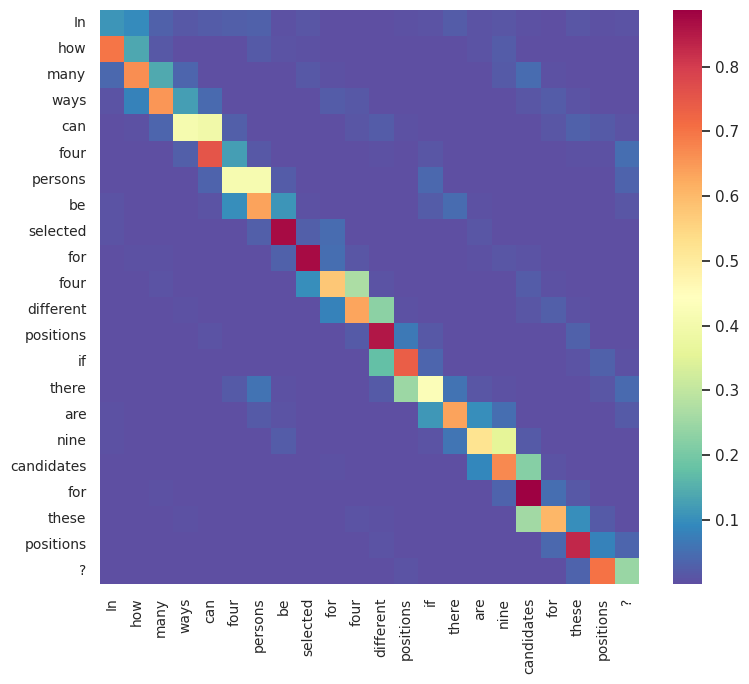

In [27]:
draw_first_layer_attention_maps(
    text=sample_1, 
    model=rubert_tiny_init, 
    tokenizer=rubert_tiny_tokenizer, 
    attention_head_ids=[0]
)

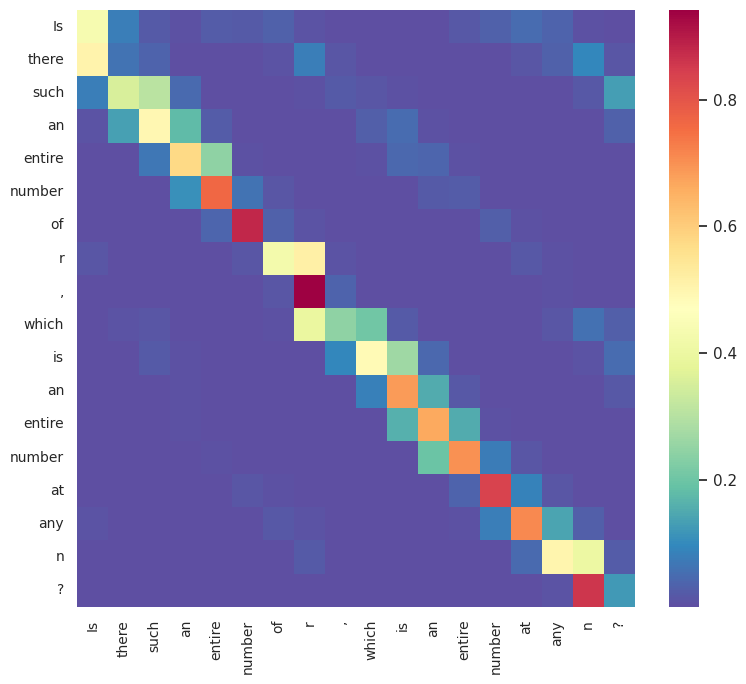

In [28]:
draw_first_layer_attention_maps(
    text=sample_2, 
    model=rubert_tiny_init, 
    tokenizer=rubert_tiny_tokenizer, 
    attention_head_ids=[0]
)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


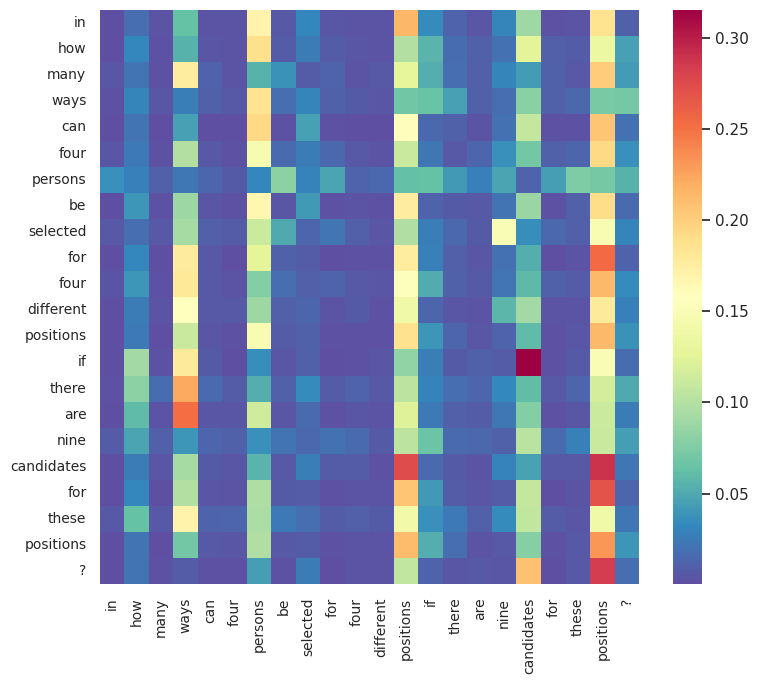

In [29]:
draw_first_layer_attention_maps(
    text=sample_1, 
    model=math_bert_init, 
    tokenizer=math_bert_tokenizer, 
    attention_head_ids=[0]
)

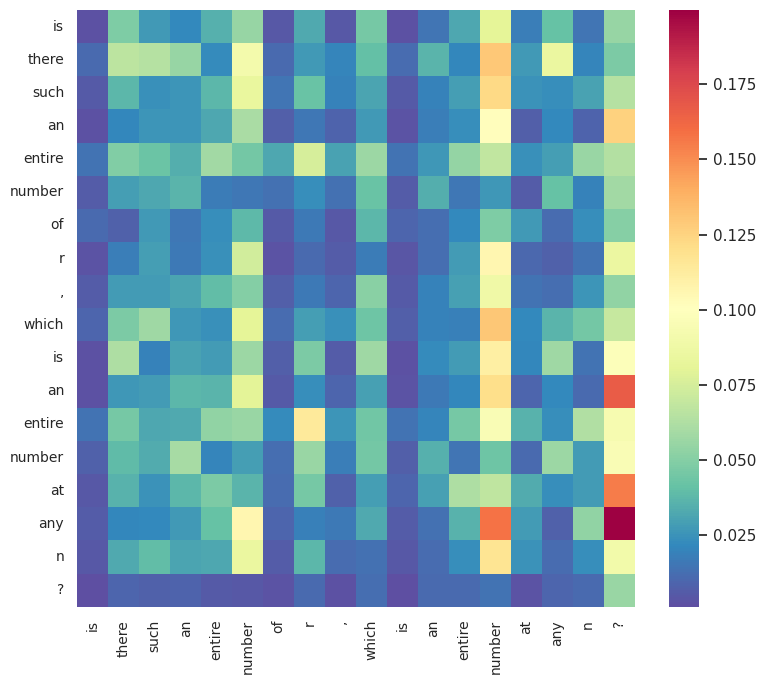

In [30]:
draw_first_layer_attention_maps(
    text=sample_2, 
    model=math_bert_init, 
    tokenizer=math_bert_tokenizer, 
    attention_head_ids=[0]
)

Модель RuBERT-Tiny2 без предварительного обучения в первом слое и первой головы фокусируется преимущественно на соседних токенах, а не на дальних связях. В отличие от RuBERT-Tiny2, модель MathBERT при первом слое обработки текста уделяет больше внимания отдельным токенам, устанавливая связи между ними на большие расстояния. 

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

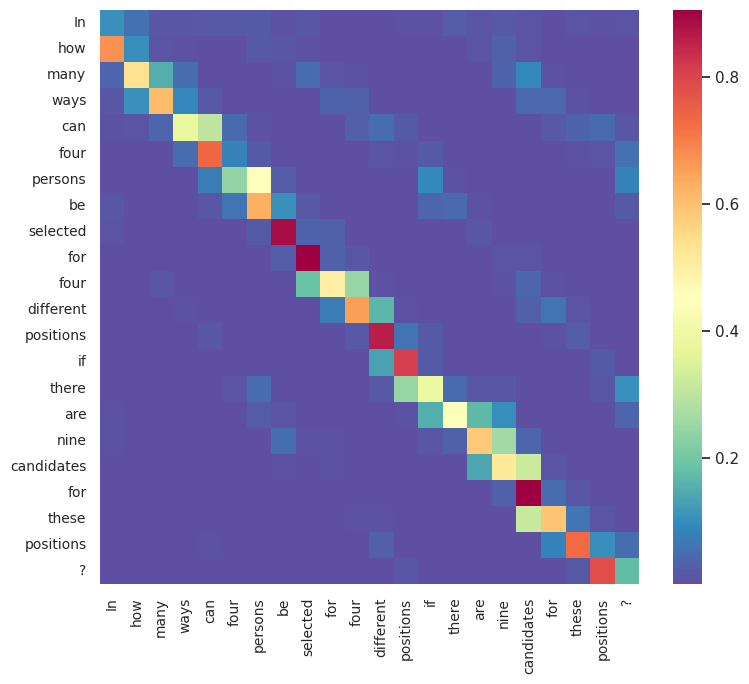

In [31]:
draw_first_layer_attention_maps(
    text=sample_1, 
    model=rubert_tiny_transformer_model, 
    tokenizer=rubert_tiny_tokenizer, 
    attention_head_ids=[0]
)

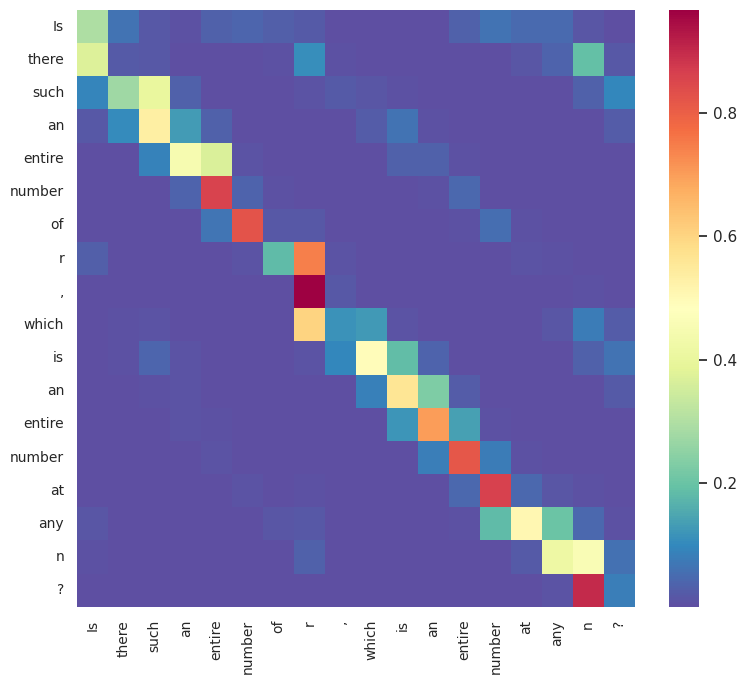

In [32]:
draw_first_layer_attention_maps(
    text=sample_2, 
    model=rubert_tiny_transformer_model, 
    tokenizer=rubert_tiny_tokenizer, 
    attention_head_ids=[0]
)

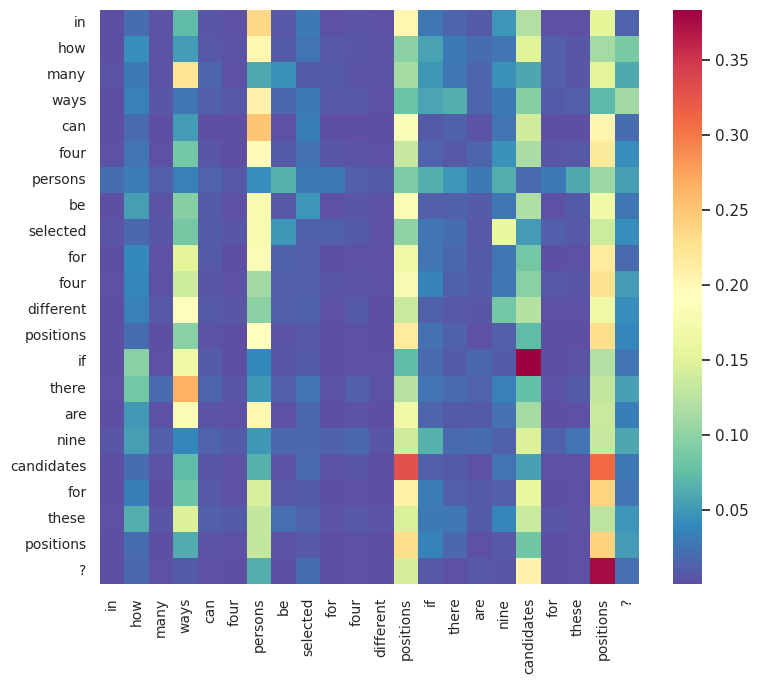

In [33]:
draw_first_layer_attention_maps(
    text=sample_1, 
    model=math_bert_transformer_model, 
    tokenizer=math_bert_tokenizer, 
    attention_head_ids=[0]
)

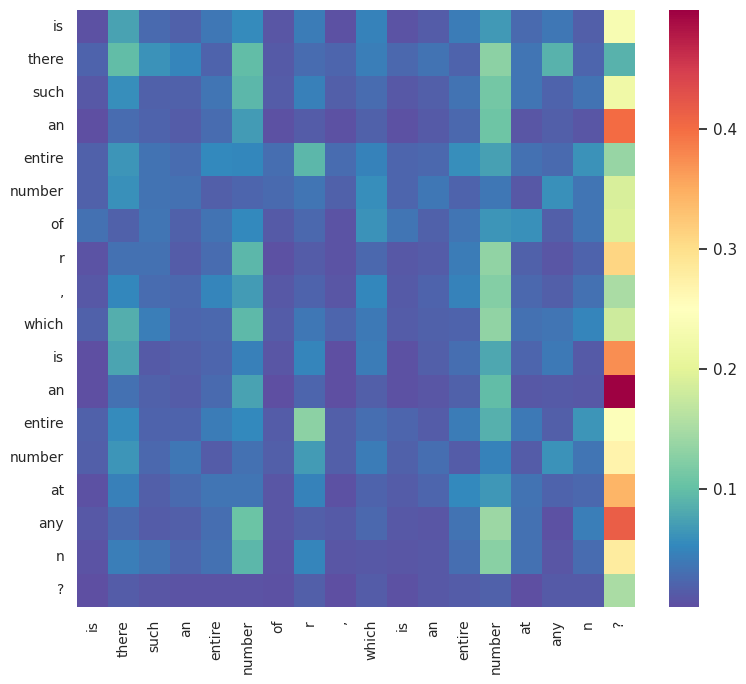

In [34]:
draw_first_layer_attention_maps(
    text=sample_2, 
    model=math_bert_transformer_model, 
    tokenizer=math_bert_tokenizer, 
    attention_head_ids=[0]
)

После дообучения модели демонстрируют схожее поведение с тем, что наблюдалось при использовании изначальных параметров. Однако, в MathBERT отмечается снижение разреженности масок, что указывает на более точечную концентрацию внимания на отдельных токенах предложения.